## Grokking modular arithmetic

[[2301.02679] Grokking modular arithmetic](https://arxiv.org/abs/2301.02679)

Given a natural number $N$, we have modular arithmetic on $\mathbb Z_N = \{0, 1, ..., N-1\}$. For example, $\mathbb Z_{12}$ is the "clock face modular arithmetic". The problem for our neural network is to learn binary functions on $\mathbb Z_N$.

Each such binary function can be exactly specified by a $N\times N$ table. There are $N^{N^2}$ possible tables. Most of them are completely random and uninteresting, both for us and for neural networks, but a few are very interesting, and modular addition is one such interesting function.

For example, modular addition in $\mathbb Z_6$ has the following multiplicative table:

| +  | 0 | 1 | 2 | 3 | 4 | 5 |
|----|---|---|---|---|---|---|
| 0  | 0 | 1 | 2 | 3 | 4 | 5 |
| 1  | 1 | 2 | 3 | 4 | 5 | 0 |
| 2  | 2 | 3 | 4 | 5 | 0 | 1 |
| 3  | 3 | 4 | 5 | 0 | 1 | 2 |
| 4  | 4 | 5 | 0 | 1 | 2 | 3 |
| 5  | 5 | 0 | 1 | 2 | 3 | 4 |

Since the dataset is exactly known, we can define a ratio $\alpha = \frac{|D_{train}|}{|D|}$, where $D$ is the full dataset (the multiplication table), and $D_{train}$ is the training dataset. We expect the network to learn better with higher $\alpha$.

The network architecture we would use has 3 layers:
* Input is $x = [x^{(1)}, x^{(2)}]$. Both $x^{(1)}, x^{(2)} \in \mathbb R^N$ are one-hot encodings of $\mathbb Z_N$.
* Hidden layer activation is $z = \phi(\frac{1}{\sqrt M} W^{(1)}z)$, where $\phi$ is the activation function. Here $z \in \mathbb R^M$ can be of any width.
* Output is $y = \frac 1N W^{(2)}z$, where $y \in \mathbb R^N$ should be a one-hot encoding of $\mathbb Z_N$.
* All entries of $W^{(1)}, W^{(2)} \sim \mathcal N(0, 1)$ are initialized as standard gaussians.
* $W^{(1)}, W^{(2)}$ are all the parameters of the network. There is no bias. Thus the network has $3MN$ parameters in total.

An example network is drawn below, with $N=3, M = 10$.


![](network.png)

Grokking occurs under different choices of activation functions $\phi$, different training methods (SGD, Adam, etc), and different training set ratio $\alpha$.

The simplest example where grokking occurs is with
* Quadratic activation function: $\phi(t) = t^2$.
* Full gradient descent (the entire training set is used every gradient descent step).
* MSE loss.

We use AdamW optimizer since it saves time.



## Coding

### Construct the dataset

First we construct the dataset. The dataset is formatted as an array of triples of form $(x_1, x_2, y)$, interpreted as $x_1 + x_2 = y \mod N$. We first construct the multiplication table, then split it randomly into two datasets.

In [1]:
N = 12
M = 10
alpha = 0.49

In [2]:
import numpy as np

def mod_add_table(N):
    return (np.arange(N).reshape(-1,1) + np.arange(N).reshape(1,-1)) % N

full_set = mod_add_table(N)
print(full_set)

# reshape to (N*N, 3), where each row is (x1, x2, x1+x2)
pairs_and_sums = np.array([(x1, x2, full_set[x1, x2]) for x1 in range(N) for x2 in range(N)])

np.random.shuffle(pairs_and_sums)
train_set = pairs_and_sums[:int(alpha * len(pairs_and_sums))]
test_set = pairs_and_sums[int(alpha * len(pairs_and_sums)):]

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 1  2  3  4  5  6  7  8  9 10 11  0]
 [ 2  3  4  5  6  7  8  9 10 11  0  1]
 [ 3  4  5  6  7  8  9 10 11  0  1  2]
 [ 4  5  6  7  8  9 10 11  0  1  2  3]
 [ 5  6  7  8  9 10 11  0  1  2  3  4]
 [ 6  7  8  9 10 11  0  1  2  3  4  5]
 [ 7  8  9 10 11  0  1  2  3  4  5  6]
 [ 8  9 10 11  0  1  2  3  4  5  6  7]
 [ 9 10 11  0  1  2  3  4  5  6  7  8]
 [10 11  0  1  2  3  4  5  6  7  8  9]
 [11  0  1  2  3  4  5  6  7  8  9 10]]


In [3]:
import numpy as np

def mod_add_table(N):
    return (np.arange(N).reshape(-1,1) + np.arange(N).reshape(1,-1)) % N

full_set = mod_add_table(N)
print(full_set)

# reshape to (N*N, 3), where each row is (x1, x2, x1+x2)
pairs_and_sums = np.array([(x1, x2, full_set[x1, x2]) for x1 in range(N) for x2 in range(N)])

np.random.shuffle(pairs_and_sums)
train_set = pairs_and_sums[:int(alpha * len(pairs_and_sums))]
test_set = pairs_and_sums[int(alpha * len(pairs_and_sums)):]

import torch
import torch.nn.functional as F

def one_hot_encode(dataset, N):
    inputs = dataset[:, :2]
    targets = dataset[:, 2]

    # Convert inputs and targets to one-hot vectors
    inputs_one_hot = F.one_hot(inputs, num_classes=N).float()
    targets_one_hot = F.one_hot(targets, num_classes=N).float()

    # Reshape inputs from [dataset_size, 2, N] to [dataset_size, 2*N]
    inputs_one_hot = inputs_one_hot.view(-1, 2*N)
    return inputs_one_hot, targets_one_hot

train_inputs_one_hot, train_targets_one_hot = one_hot_encode(torch.from_numpy(train_set).long(), N)
test_inputs_one_hot, test_targets_one_hot = one_hot_encode(torch.from_numpy(test_set).long(), N)

for i in range(3):
    print(train_set[i])
    print(train_inputs_one_hot[i,:N])
    print(train_inputs_one_hot[i,N:])
    print(train_targets_one_hot[i,:])

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 1  2  3  4  5  6  7  8  9 10 11  0]
 [ 2  3  4  5  6  7  8  9 10 11  0  1]
 [ 3  4  5  6  7  8  9 10 11  0  1  2]
 [ 4  5  6  7  8  9 10 11  0  1  2  3]
 [ 5  6  7  8  9 10 11  0  1  2  3  4]
 [ 6  7  8  9 10 11  0  1  2  3  4  5]
 [ 7  8  9 10 11  0  1  2  3  4  5  6]
 [ 8  9 10 11  0  1  2  3  4  5  6  7]
 [ 9 10 11  0  1  2  3  4  5  6  7  8]
 [10 11  0  1  2  3  4  5  6  7  8  9]
 [11  0  1  2  3  4  5  6  7  8  9 10]]
[ 4  7 11]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
[11  7  6]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
[10  3  1]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.

In [4]:
def generate_dataset(N, alpha):
    full_set = (np.arange(N).reshape(-1,1) + np.arange(N).reshape(1,-1)) % N
    pairs_and_sums = np.array([(x1, x2, full_set[x1, x2]) for x1 in range(N) for x2 in range(N)])

    np.random.shuffle(pairs_and_sums)
    train_set = pairs_and_sums[:int(alpha * len(pairs_and_sums))]
    test_set = pairs_and_sums[int(alpha * len(pairs_and_sums)):]

    def one_hot_encode(dataset, N):
        inputs = dataset[:, :2]
        targets = dataset[:, 2]

        # Convert inputs and targets to one-hot vectors
        inputs_one_hot = F.one_hot(inputs, num_classes=N).float()
        targets_one_hot = F.one_hot(targets, num_classes=N).float()

        # Reshape inputs from [dataset_size, 2, N] to [dataset_size, 2*N]
        inputs_one_hot = inputs_one_hot.view(-1, 2*N)

        return inputs_one_hot, targets_one_hot

    train_inputs_one_hot, train_targets_one_hot = one_hot_encode(torch.from_numpy(train_set).long(), N)
    test_inputs_one_hot, test_targets_one_hot = one_hot_encode(torch.from_numpy(test_set).long(), N)

    return train_inputs_one_hot, train_targets_one_hot, test_inputs_one_hot, test_targets_one_hot

### Defining the neural network

The network is defined in PyTorch and uses 3 layers.

In [5]:
import torch
import torch.nn as nn

class GrokNet(nn.Module):
    def __init__(self, N, M):
        super(GrokNet, self).__init__()
        self.N = torch.tensor(N, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.W1 = nn.Parameter(torch.randn(2*N, M))
        self.W2 = nn.Parameter(torch.randn(M, N))

    def forward(self, x):
        z = torch.square(x @ self.W1  / torch.sqrt(self.M))
        y = (z @ self.W2) / self.N
        return y

    def hidden(self, x):
        with torch.no_grad():
            return torch.square(x @ self.W1  / torch.sqrt(self.M))

In [6]:
from tqdm import trange
import torch.optim as optim
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "Please turn on GPU accelerator. On Google Colab, it is Runtime -> Change runtime type -> GPU"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N, M = 40, 120
alpha = 0.4

train_inputs_one_hot, train_targets_one_hot, test_inputs_one_hot, test_targets_one_hot = generate_dataset(N, alpha)
model = GrokNet(N=N, M=M)

# Move to GPU
model = model.to(device)
train_inputs_one_hot = train_inputs_one_hot.to(device)
train_targets_one_hot = train_targets_one_hot.to(device)
test_inputs_one_hot = test_inputs_one_hot.to(device)
test_targets_one_hot = test_targets_one_hot.to(device)

# optimizer and loss function
optimizer = optim.AdamW(model.parameters())
criterion = torch.nn.MSELoss()

epochs = 20000
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
train_accuracies = np.zeros(epochs)
test_accuracies = np.zeros(epochs)

# Training Loop
progress_bar = trange(epochs)
for epoch in progress_bar:
    # Forward pass
    outputs = model(train_inputs_one_hot)
    # Compute loss
    loss = criterion(outputs, train_targets_one_hot)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store loss
    train_losses[epoch] = loss.item()

    train_acc = (outputs.argmax(dim=1) == train_targets_one_hot.argmax(dim=1)).float().mean().item()
    train_accuracies[epoch] = train_acc

    # Evaluate on test set
    with torch.no_grad():
        test_outputs = model(test_inputs_one_hot)
        test_loss = criterion(test_outputs, test_targets_one_hot)
        test_losses[epoch] = test_loss.item()
        test_acc = (test_outputs.argmax(dim=1) == test_targets_one_hot.argmax(dim=1)).float().mean().item()
        test_accuracies[epoch] = test_acc

    progress_bar.set_postfix({"train accuracy": f"{train_acc:.4f}", "test accuracy": f"{test_acc:.4f}"})

100%|██████████| 20000/20000 [02:08<00:00, 155.63it/s, train accuracy=1.0000, test accuracy=1.0000]


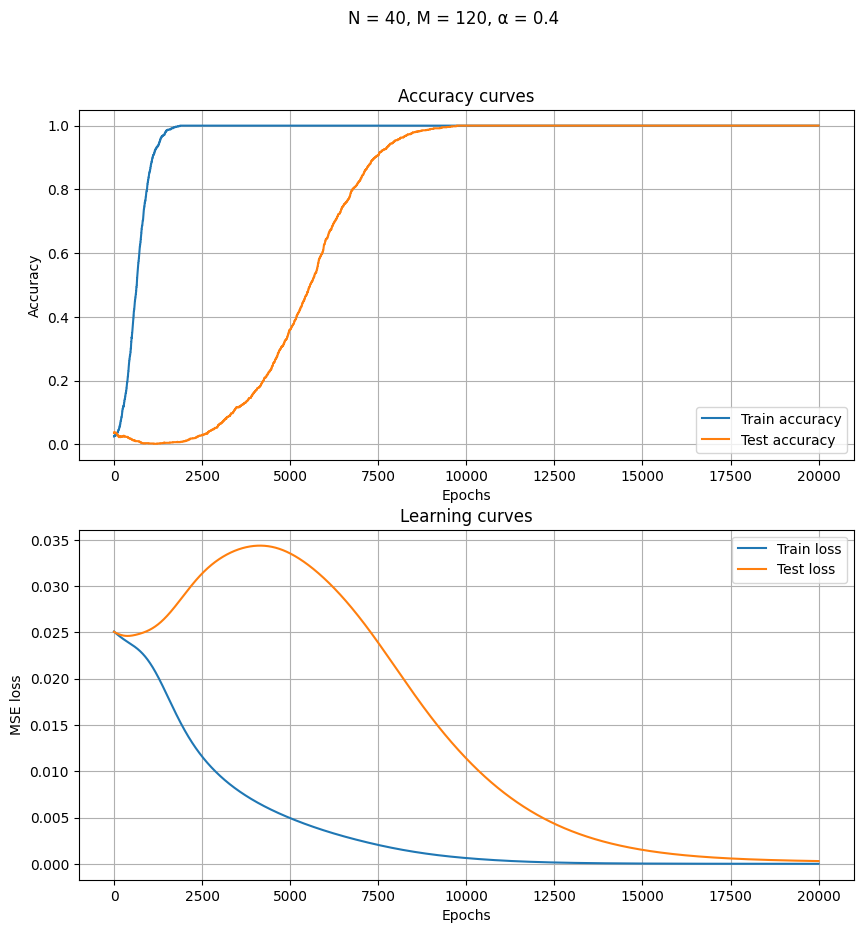

In [7]:
fig, axes = plt.subplot_mosaic([['Accuracy'], ['Loss']], figsize=(10, 10))

ax = axes['Accuracy']
ax.plot(train_accuracies, label="Train accuracy")
ax.plot(test_accuracies, label="Test accuracy")
ax.set(title=f'Accuracy curves', xlabel='Epochs', ylabel='Accuracy')
ax.legend()
ax.grid()

ax = axes['Loss']
ax.plot(train_losses, label="Train loss")
ax.plot(test_losses, label="Test loss")
ax.set(title=f'Learning curves', xlabel='Epochs', ylabel='MSE loss')
ax.legend()
ax.grid()

fig.suptitle(f"N = {N}, M = {M}, α = {alpha}")
plt.show()

## Observations

* The testset accuracy curve *decreases* as trainset accuracy increases to perfection.
* The testset accuracy curves rises only after trainset accuracy is perfect. First slowly, then rapidly ("grokking"). This can be quite puzzling, since if the network has really achieved perfection on the training set, then there is nothing left to learn, and so it shouldn't be able to improve any further -- and yet it does improve.
* Perfect accuracy on trainset is reached at epoch 10x that of trainset.
* The learning curves shows something smoother, but also something interesting: the train loss decreases monotonically, but the test loss rises, then decreases.
* For a while, test loss rose *while* test accuracy increased!

Some lessons:

* Grokking might look less dramatic when plotted not by argmax-accuracy, but by MSE.
  * See for example [[2201.02177] Grokking: Generalization Beyond Overfitting on Small Algorithmic Datasets](https://arxiv.org/abs/2201.02177). One wonders what they would have found if they had plotted MSE losses instead of accuracies?
  * [[2301.05217] Progress measures for grokking via mechanistic interpretability](https://arxiv.org/abs/2301.05217) does plot train and test loss, and in this paper, the grokking appears in the loss curves as well. This seems harder to understand using our small model (they used a Transformer).
* Train loss can decrease while test loss increase, but this trend can also be reversed. The shape of learning curves is quite complex.


## Simple interpretations

Let's try to interpret what the neural network has learned. Since our network is so small, we are able to actually plot every single one of its weights.

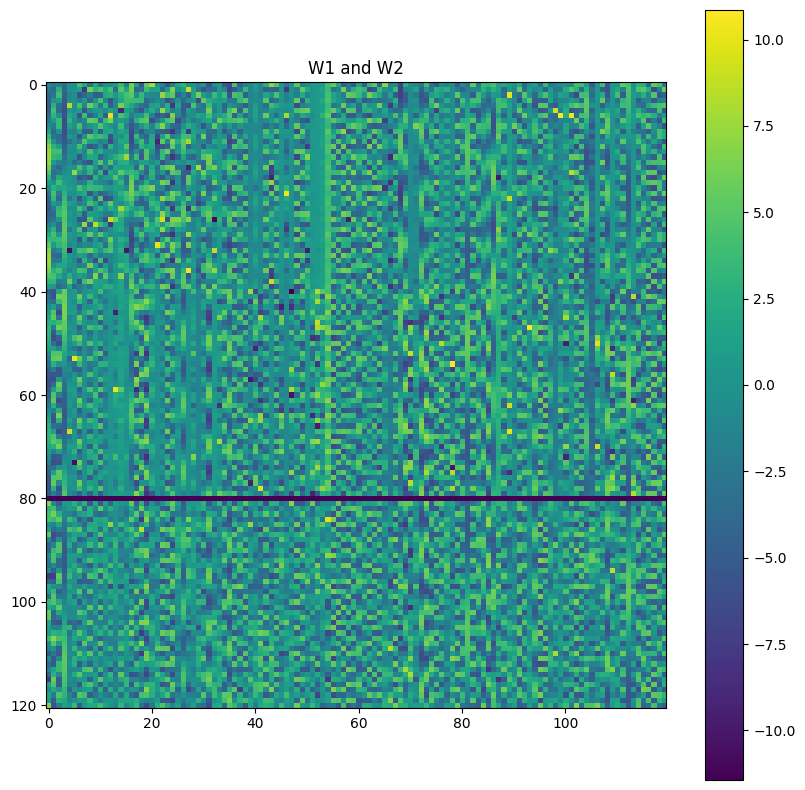

In [26]:
def visualize_network(W1, W2, title):
    # Find minimal value for the separator
    min_val = min(W1.min(), W2.min())

    # Create a "black" separator
    separator = np.full((1, W1.shape[1]), min_val)

    # Stack everything together
    W = np.concatenate((W1, separator, W2), axis=0)

    # Now you can use plt.imshow to visualize the stacked matrices
    plt.figure(figsize=(10, 10))
    cax = plt.imshow(W, cmap='viridis')
    plt.colorbar(cax)
    plt.title(title)
    plt.show()

W1 = model.W1.detach().cpu().numpy()
W2 = model.W2.T.detach().cpu().numpy()
visualize_network(W1, W2, 'W1 and W2')

We notice some strange bands that look strongly suggestive of sine waves. Let's try to order them, left to right, according to how fast they are oscillating.

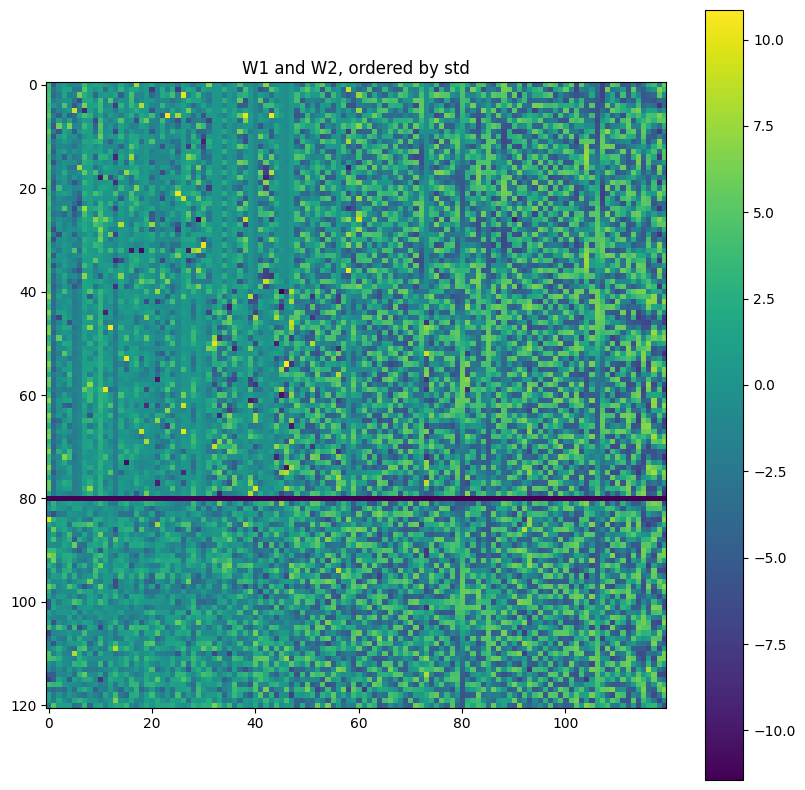

In [30]:
def visualize_network_std(W1, W2):
    # Compute the standard deviation along each column in W1
    std_devs = np.std(W1, axis=0)

    # Get the order of indices that would sort the standard deviations
    order = np.argsort(std_devs)

    # Reorder the columns of W1 and rows of W2 using these indices
    W1_ordered = W1[:, order]
    W2_ordered = W2[:, order]

    visualize_network(W1_ordered, W2_ordered, 'W1 and W2, ordered by std')

visualize_network_std(W1, W2)

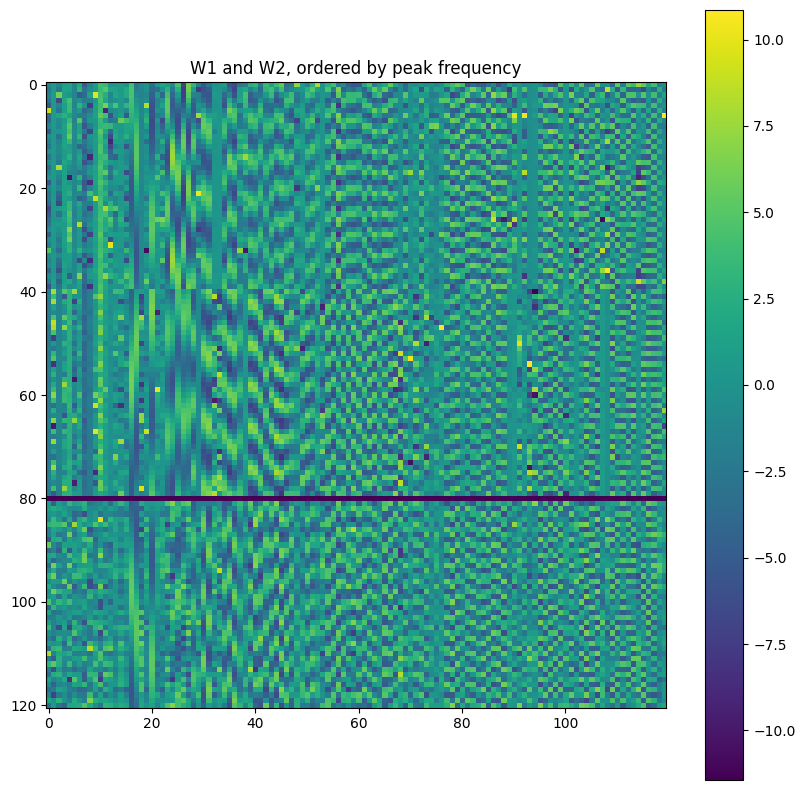

In [37]:
from scipy.fftpack import fft

def get_fft_order(W1, W2):
    # Compute power spectrum for each column in W1 (split to two) and W2
    power_spectrums = np.abs(fft(W1[:N,:], axis=0))**2
    power_spectrums += np.abs(fft(W1[N:,:], axis=0))**2
    power_spectrums += np.abs(fft(W2, axis=0))**2

    # Find the peak frequency for each column
    peak_freqs = np.argmax(power_spectrums, axis=0)

    # Get the order of indices that would sort the peak frequencies
    order = np.argsort(peak_freqs)
    return order

def visualize_network_fft(W1, W2):
    order = get_fft_order(W1, W2)
    W1_ordered = W1[:, order]
    W2_ordered = W2[:, order]

    visualize_network(W1_ordered, W2_ordered, 'W1 and W2, ordered by peak frequency')

visualize_network_fft(W1, W2)

When performing experiments, it is of vital importance to check the null hypothesis. While we seem to see some very suggestive pictures, we should make sure it's not an artifact of our experimental technique.

So, let's generate some random networks of the same architecture, but untrained. We should expect them to look like noise.

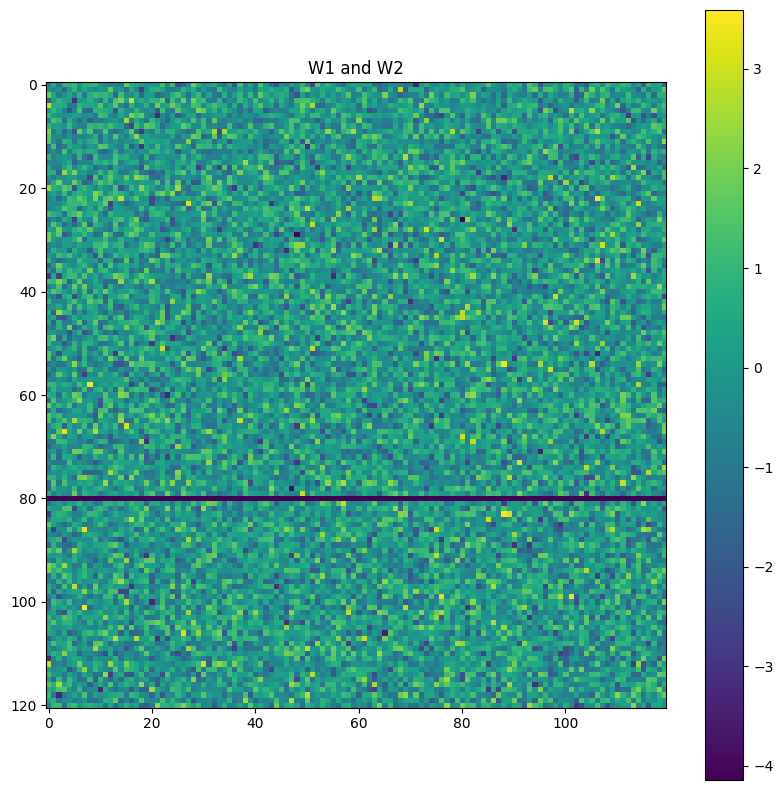

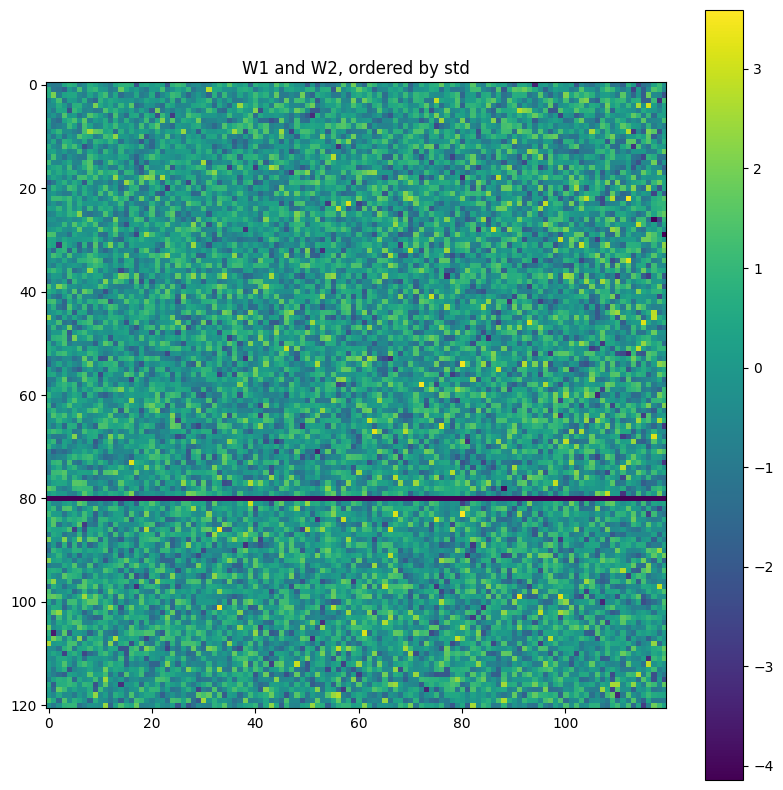

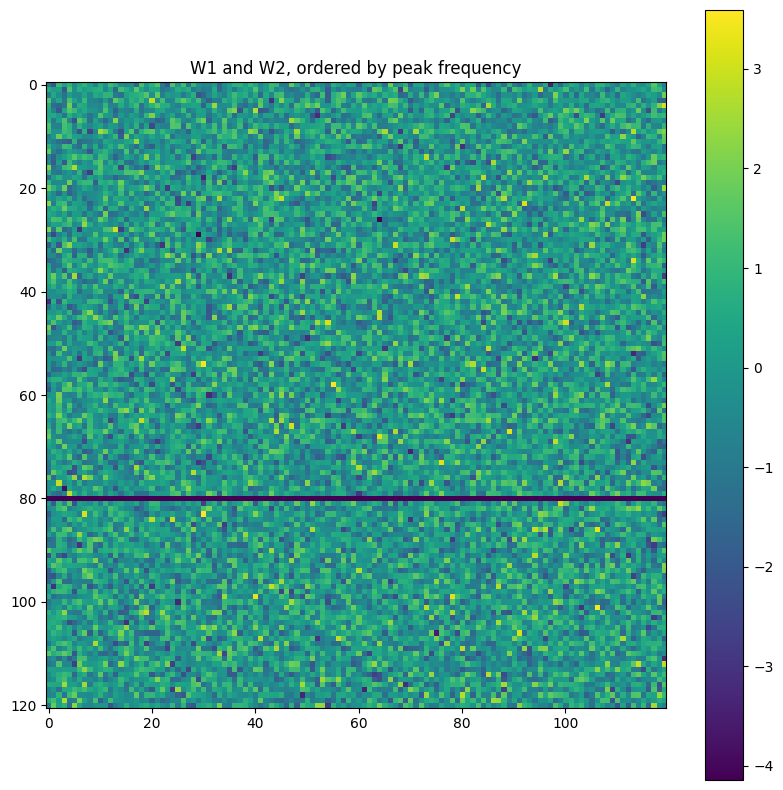

In [32]:
########################################################################
# TODO: your answer here
########################################################################
model_noise = GrokNet(N=N, M=M)

W1_noise = model_noise.W1.detach().cpu().numpy()
W2_noise = model_noise.W2.T.detach().cpu().numpy()
visualize_network(W1_noise, W2_noise, 'W1 and W2')
visualize_network_std(W1_noise, W2_noise)
visualize_network_fft(W1_noise, W2_noise)
########################################################################

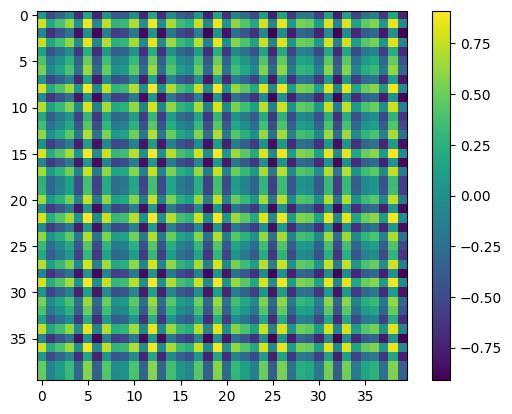

In [47]:
import numpy as np
import torch

def pre_activation_mapping(N, k, W1):
    activations = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            one_hot_i = F.one_hot(torch.tensor(i), num_classes=N).float().view(1,-1)
            one_hot_j = F.one_hot(torch.tensor(j), num_classes=N).float().view(1,-1)
            combined = torch.cat([one_hot_i, one_hot_j], dim=1)
            z = combined @ W1 / np.sqrt(model.M)
            activations[i, j] = z[0, k].item()
    return activations

activations = pre_activation_mapping(40, 10, W1)
plt.imshow(activations, cmap='viridis')
plt.colorbar()
plt.show()

In [48]:
def generate_activation_plot(N, W1, order):
    margin = 3
    N1, N2 = 10, 10
    full_array = np.full(((N + margin) * N1, (N + margin) * N2), -0.6)

    for n in trange(N1 * N2):
        n1, n2 = n // N2, n % N2
        k = order[N1 * n1 + n2]
        activations = pre_activation_mapping(N, k, W1)
        full_array[n1 * (N + margin): n1 * (N + margin) + N, n2 * (N + margin): n2 * (N + margin) + N] = activations
    plt.figure(figsize=(20,20))
    plt.imshow(full_array, cmap='viridis')
    plt.axis('off')
    plt.show()

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


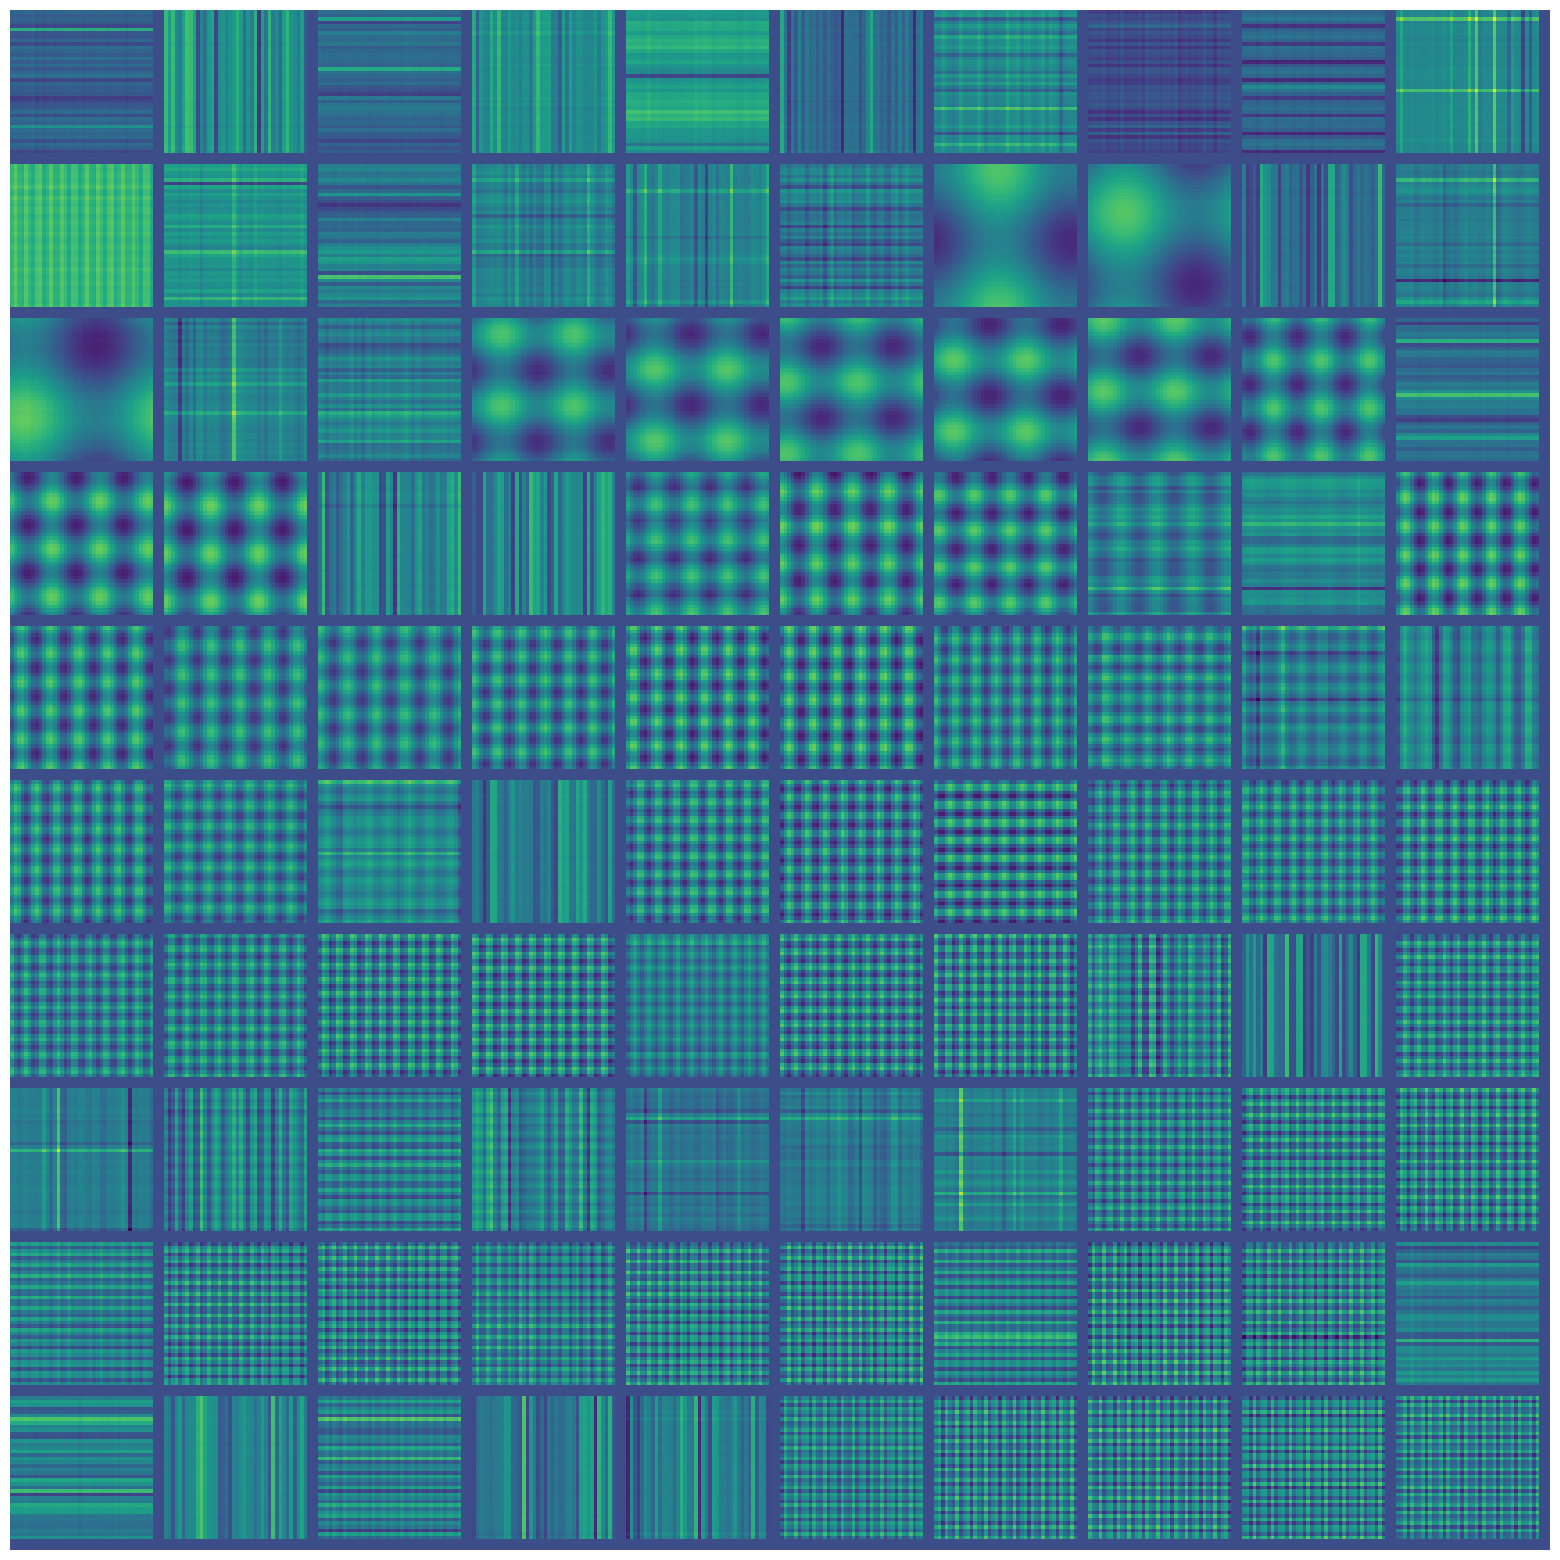

In [49]:
order = get_fft_order(W1, W2)
generate_activation_plot(40, W1, order)

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


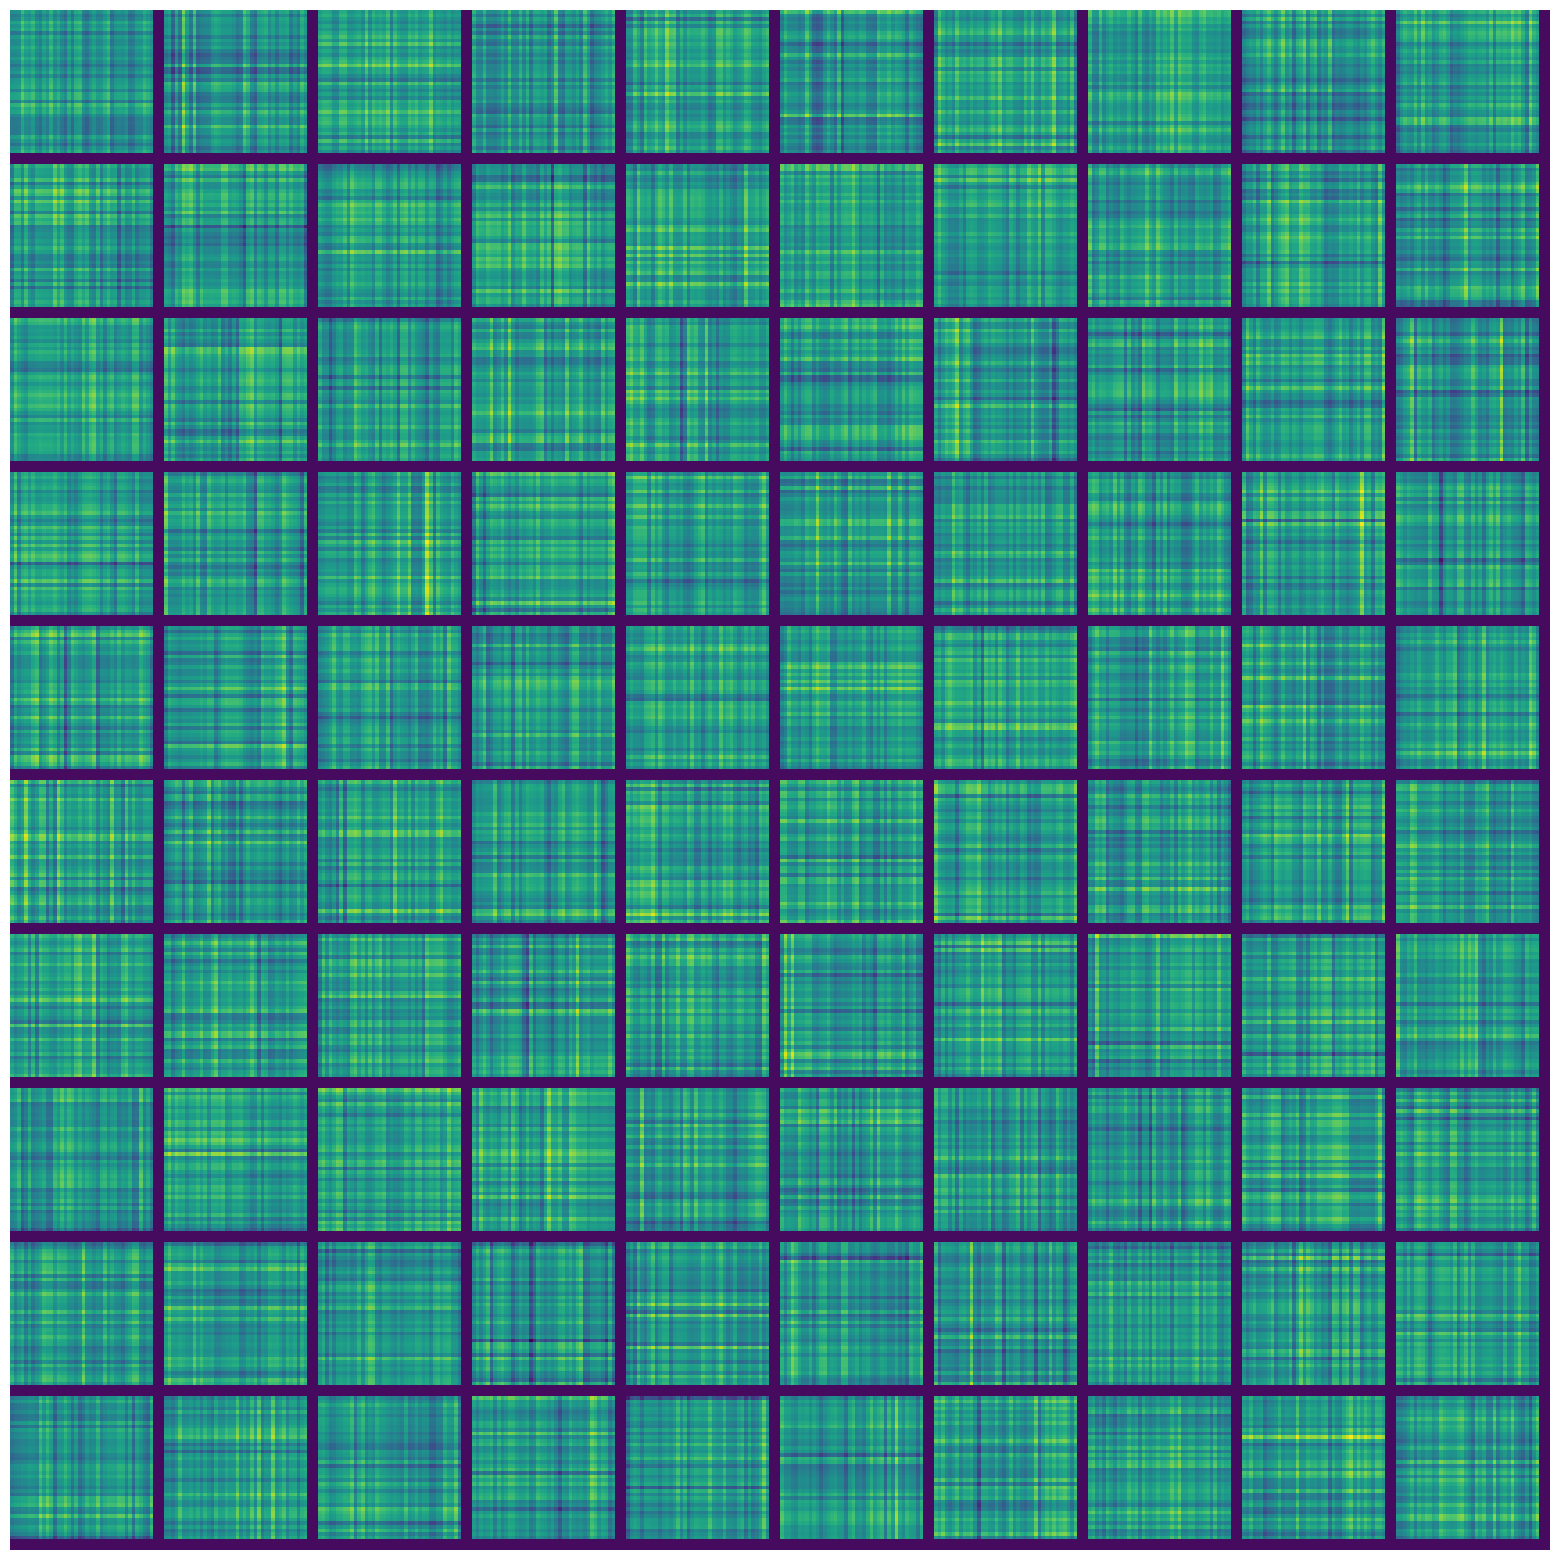

In [50]:
########################################################################
# TODO: your answer here
########################################################################
model_noise = GrokNet(N=N, M=M)

W1_noise = model_noise.W1.detach().cpu().numpy()
W2_noise = model_noise.W2.T.detach().cpu().numpy()
order = get_fft_order(W1_noise, W2_noise)
generate_activation_plot(40, W1_noise, order)
########################################################################

We see that the network has learned some sine waves. It seems to be a robust fact that networks trained to do modular arithmetics, with one-hot encoding, learns to use trigonometry for this task. (the use of one-hot encoding seems very relevant, as [noted here](https://www.lesswrong.com/posts/tdENX8dzdro8PXAzP/short-remark-on-the-subjective-mathematical-naturalness-of)).

## Extensions

Try this activity with other configurations and report what you found. Suggestions:
* Modular multiplication.
* Random operation (as a null hypothesis).
* Different activation functions (sine, ReLU).
* Different accelerators (SGD, Adam, etc)
* Two hidden layers.

In [51]:
########################################################################
# TODO: your answer here
########################################################################

# This example answer runs the same experiment where the binary operation
# to be learned is entirely random. As we will see, it makes
# the model completely unable to perform on the test set,
# and the weights of the trained network are indistinguishable from white noise.

def generate_random_dataset(N, alpha):
    full_set = np.random.randint(0, N, (N, N))
    pairs_and_sums = np.array([(x1, x2, full_set[x1, x2]) for x1 in range(N) for x2 in range(N)])

    np.random.shuffle(pairs_and_sums)
    train_set = pairs_and_sums[:int(alpha * len(pairs_and_sums))]
    test_set = pairs_and_sums[int(alpha * len(pairs_and_sums)):]

    def one_hot_encode(dataset, N):
        inputs = dataset[:, :2]
        targets = dataset[:, 2]

        # Convert inputs and targets to one-hot vectors
        inputs_one_hot = F.one_hot(inputs, num_classes=N).float()
        targets_one_hot = F.one_hot(targets, num_classes=N).float()

        # Reshape inputs from [dataset_size, 2, N] to [dataset_size, 2*N]
        inputs_one_hot = inputs_one_hot.view(-1, 2*N)

        return inputs_one_hot, targets_one_hot

    train_inputs_one_hot, train_targets_one_hot = one_hot_encode(torch.from_numpy(train_set).long(), N)
    test_inputs_one_hot, test_targets_one_hot = one_hot_encode(torch.from_numpy(test_set).long(), N)

    return train_inputs_one_hot, train_targets_one_hot, test_inputs_one_hot, test_targets_one_hot

N, M = 40, 120
alpha = 0.4

train_inputs_one_hot, train_targets_one_hot, test_inputs_one_hot, test_targets_one_hot = generate_random_dataset(N, alpha)
model = GrokNet(N=N, M=M)

# Move to GPU
model = model.to(device)
train_inputs_one_hot = train_inputs_one_hot.to(device)
train_targets_one_hot = train_targets_one_hot.to(device)
test_inputs_one_hot = test_inputs_one_hot.to(device)
test_targets_one_hot = test_targets_one_hot.to(device)

# optimizer and loss function
optimizer = optim.AdamW(model.parameters())
criterion = torch.nn.MSELoss()

epochs = 20000
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
train_accuracies = np.zeros(epochs)
test_accuracies = np.zeros(epochs)

# Training Loop
progress_bar = trange(epochs)
for epoch in progress_bar:
    # Forward pass
    outputs = model(train_inputs_one_hot)
    # Compute loss
    loss = criterion(outputs, train_targets_one_hot)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store loss
    train_losses[epoch] = loss.item()

    train_acc = (outputs.argmax(dim=1) == train_targets_one_hot.argmax(dim=1)).float().mean().item()
    train_accuracies[epoch] = train_acc

    # Evaluate on test set
    with torch.no_grad():
        test_outputs = model(test_inputs_one_hot)
        test_loss = criterion(test_outputs, test_targets_one_hot)
        test_losses[epoch] = test_loss.item()
        test_acc = (test_outputs.argmax(dim=1) == test_targets_one_hot.argmax(dim=1)).float().mean().item()
        test_accuracies[epoch] = test_acc

    progress_bar.set_postfix({"train accuracy": f"{train_acc:.4f}", "test accuracy": f"{test_acc:.4f}"})
########################################################################

100%|██████████| 20000/20000 [01:41<00:00, 196.87it/s, train accuracy=1.0000, test accuracy=0.0188]


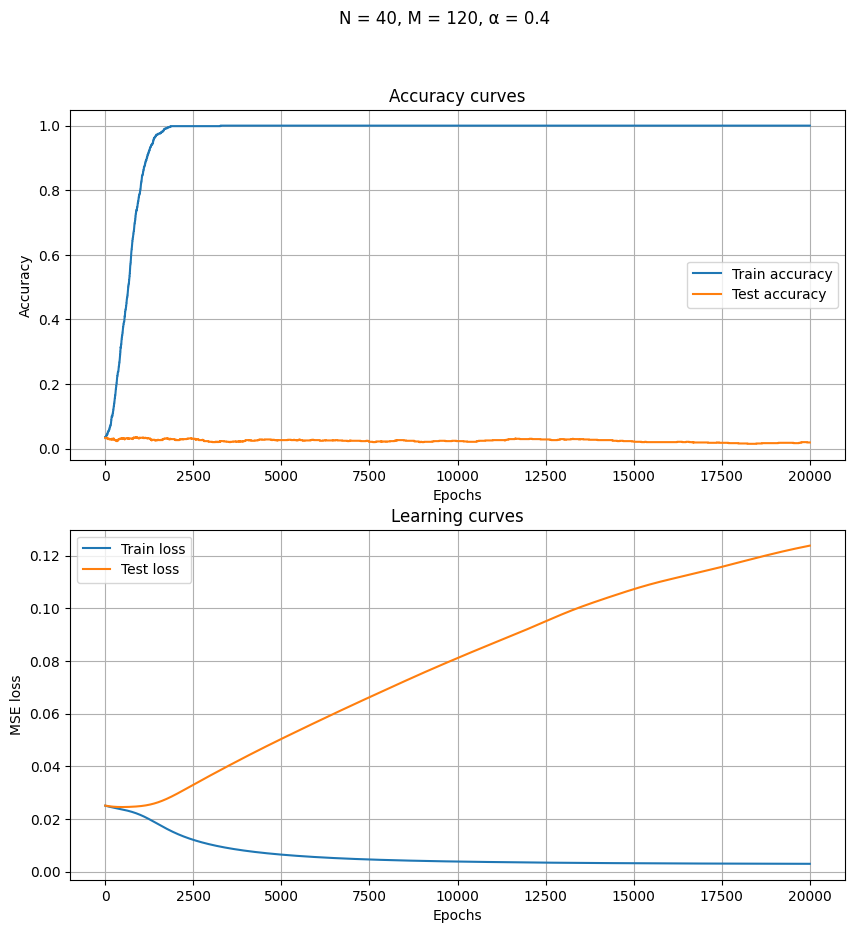

In [52]:
########################################################################
# TODO: your answer here
# No need to fill in all the TODO blocks. Those are just here
# because the automatic code-deleter can only remove codes from one cell
# at a time, and I have code spread over several cells.
########################################################################
fig, axes = plt.subplot_mosaic([['Accuracy'], ['Loss']], figsize=(10, 10))

ax = axes['Accuracy']
ax.plot(train_accuracies, label="Train accuracy")
ax.plot(test_accuracies, label="Test accuracy")
ax.set(title=f'Accuracy curves', xlabel='Epochs', ylabel='Accuracy')
ax.legend()
ax.grid()

ax = axes['Loss']
ax.plot(train_losses, label="Train loss")
ax.plot(test_losses, label="Test loss")
ax.set(title=f'Learning curves', xlabel='Epochs', ylabel='MSE loss')
ax.legend()
ax.grid()

fig.suptitle(f"N = {N}, M = {M}, α = {alpha}")
plt.show()
########################################################################

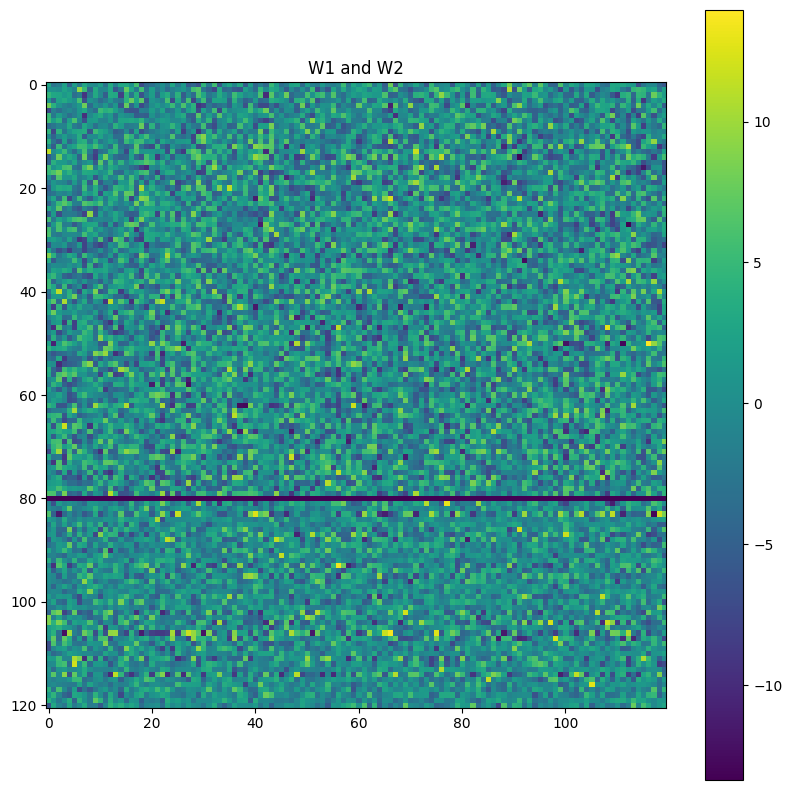

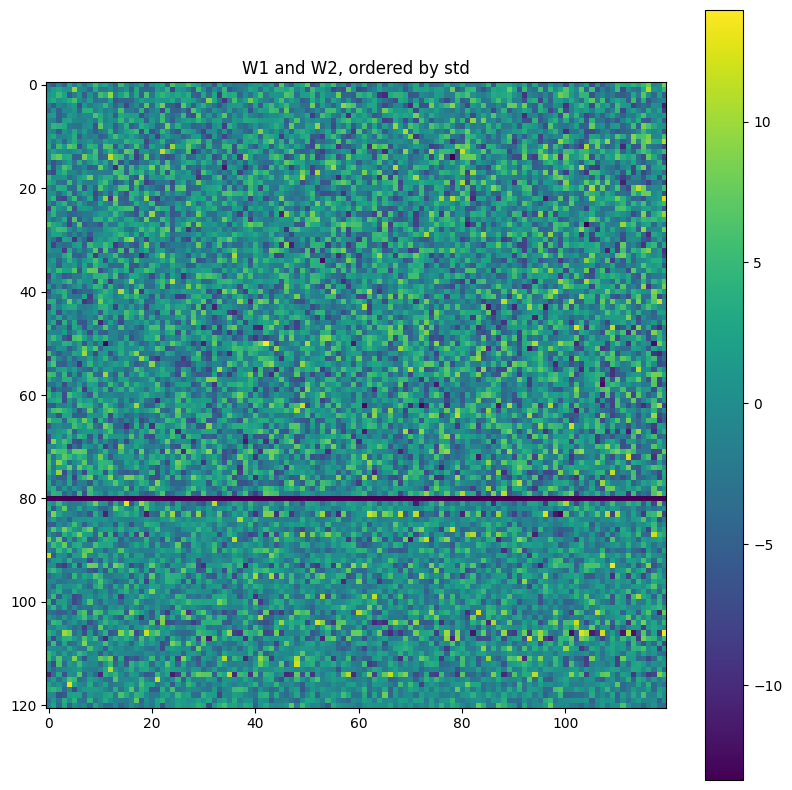

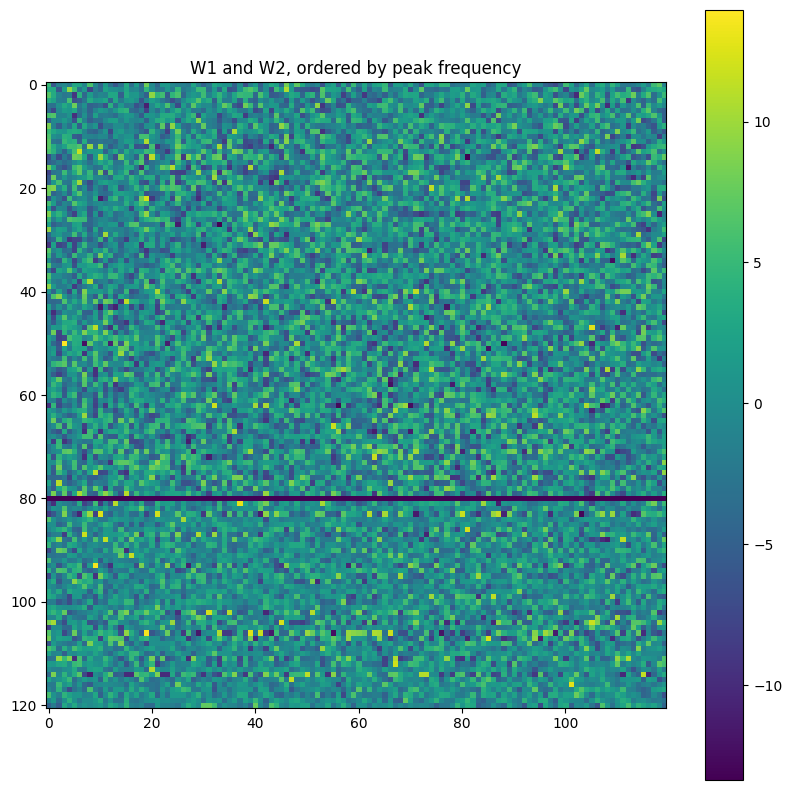

In [53]:
########################################################################
# TODO: your answer here
########################################################################
W1_noise = model.W1.detach().cpu().numpy()
W2_noise = model.W2.T.detach().cpu().numpy()
visualize_network(W1_noise, W2_noise, 'W1 and W2')
visualize_network_std(W1_noise, W2_noise)
visualize_network_fft(W1_noise, W2_noise)
########################################################################

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


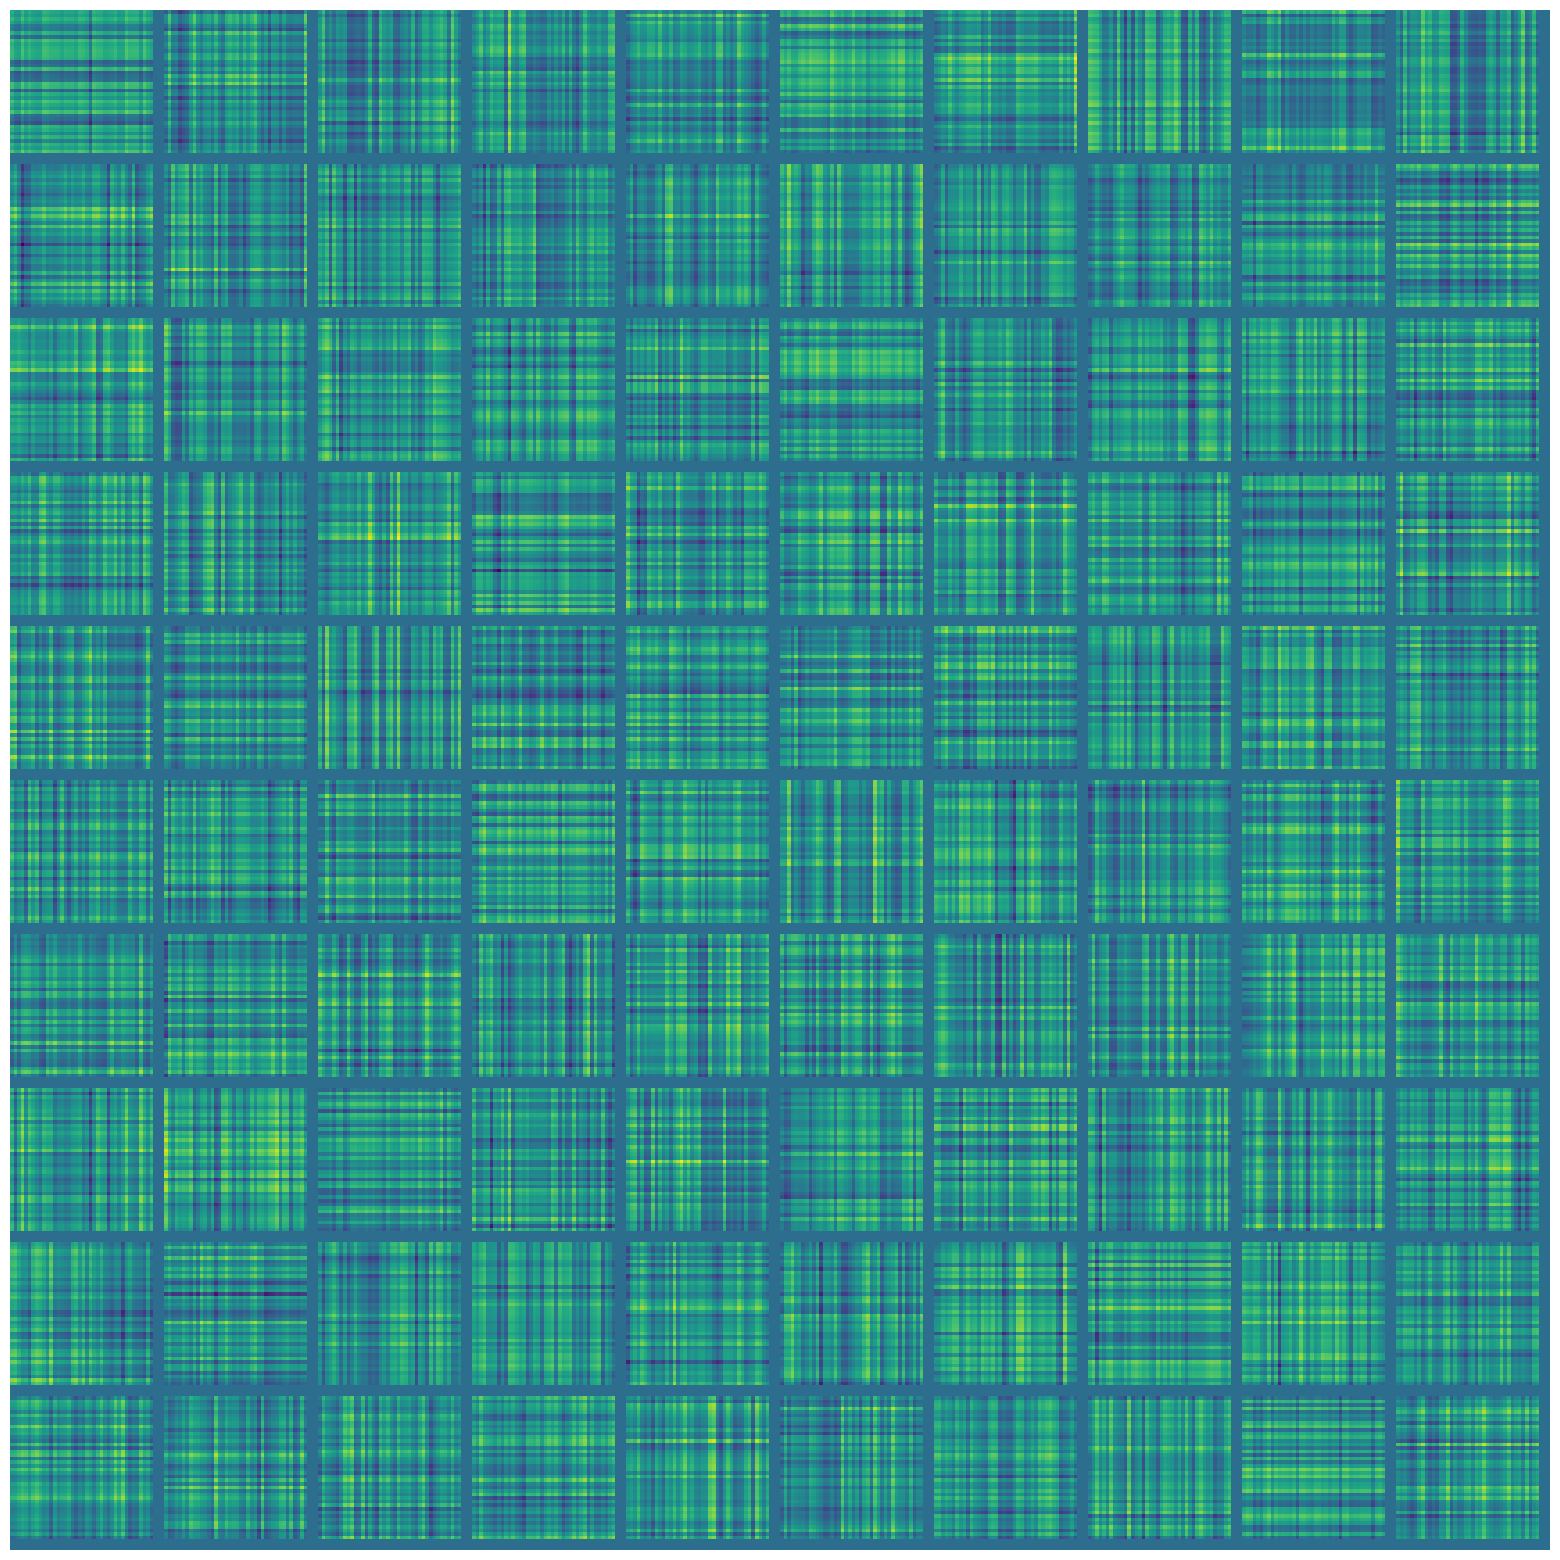

In [54]:
########################################################################
# TODO: your answer here
########################################################################
order = get_fft_order(W1_noise, W2_noise)
generate_activation_plot(40, W1_noise, order)
########################################################################

## Some other quotes

[[2301.02679] Grokking modular arithmetic](https://arxiv.org/abs/2301.02679)

> In particular, random feature models such as infinitely-wide neural networks (in the NTK regime) do not exhibit grokking, at least on the tasks that involve modular functions.
>
> In our minimal setup, the simplest explanation for grokking is that once training loss reached a certain value, the only way to further minimize it is to start learning the right features.

Geirhos, Robert, et al. "Shortcut learning in deep neural networks." Nature Machine Intelligence 2.11 (2020): 665-673.

> many of deep learning’s failures can be seen as different symptoms of the same underlying problem: shortcut learning. Shortcuts are decision rules that perform well on standard benchmarks but fail to transfer to more challenging testing conditions, such as real-world scenarios. Related issues are known in comparative psychology, education and linguistics, suggesting that shortcut learning may be a common characteristic of learning systems, biological and artificial alike.

See particularly Figure 3.

![](taxonomy_decision_rules.png)

[The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) (Richard Sutton, March 13, 2019)

> One thing that should be learned from the bitter lesson is the great power of general purpose methods, of methods that continue to scale with increased computation even as the available computation becomes very great. The two methods that seem to scale arbitrarily in this way are search and learning.

[The Scaling Hypothesis · Gwern.net](https://gwern.net/scaling-hypothesis#why-does-pretraining-work)

> Early on in training, a model learns the crudest levels: that some letters like ‘e’ are more frequent than others like ‘z’, that every 5 characters or so there is a space, and so on. It goes from predicted uniformly-distributed bytes to what looks like Base-60 encoding—alphanumeric gibberish. As crude as this may be, it’s enough to make quite a bit of absolute progress: a random predictor needs 8 bits to ‘predict’ a byte/character, but just by at least matching letter and space frequencies, it can almost halve its error to around 5 bits...
>
> ... a sample will state that someone is “alive” and then 10 sentences later, use the word “dead”, or it will digress into an irrelevant argument instead of the expected next argument, or someone will do something physically improbable, or it may just continue for a while without seeming to get anywhere.All of these errors are far less than <0.02 bits per character; we are now talking not hundredths of bits per characters but less than ten-thousandths.The pretraining thesis argues that this can go even further: we can compare this performance directly with humans doing the same objective task, who can achieve closer to 0.7 bits per character. What is in that missing >0.4?
>
> The last bits are deepest. The implication here is that the final few bits are the most valuable bits, which require the most of what we think of as intelligence.